In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=False)

#put the path to the directory with .csv files and 'images' folder on your google drive
datapath = '/content/drive/My Drive/ai-side-projects/road_segmentation/cityscapes_data/'

Mounted at /content/drive/


# Loading  [Cityscapes Image Pairs](https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs/data#) kaggle dataset, [source](https://www.cityscapes-dataset.com)

Parts of code are from my projects or [this notebook](https://www.kaggle.com/code/tr1gg3rtrash/car-driving-segmentation-unet-from-scratch/notebook), or standatd tutorials.

My goal is to make a road detection network.

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import os
from tqdm import tqdm
import cv2


# Data preparation and road mask selection

## Road mask with color filtering


Original segmentation map is not very useful since it has different possible colors for a given class (e.g. `road` is marked with magenta, but  do **not** have a constant color code).

Initial approach is to select a possible range of colors of `road` class colors and make a mask from it, but it is very noisy (see the first mask below).

I opted to smooth the mask image first and then make a magenta color mask and the image is smoother.  The resulted mask is much more continuous, but edge effects can be seen. So far I ignore it.

In [3]:
def filter_road_colors(img):
  # Define the range of RGB values for roads
  road_color_lower = np.array([110, 50, 120])
  road_color_upper = np.array([130, 70, 130])

  # Create road mask
  road_mask = np.all((img >= road_color_lower) & (img <= road_color_upper), axis=-1)

  # Convert boolean mask to an image with zeros and ones
  road_mask = road_mask.astype(np.uint8) * 255

  return road_mask


def preprocess(path, smoothing_scale = 10):
    img = Image.open(path)
    img1 = img.crop((0, 0, 256, 256))#.resize((128, 128))
    img2 = img.crop((256, 0, 512, 256))#.resize((128, 128))
    img1 = np.array(img1) / 255.
    img2 = np.array(img2)

    kernel = np.ones((smoothing_scale,smoothing_scale),np.float32)/smoothing_scale**2
    img2_smoothed = cv2.filter2D(img2,-1,kernel)

    mask2 = filter_road_colors(img2)
    mask2_smoothed = filter_road_colors(img2_smoothed)

    return img1, img2, mask2, mask2_smoothed

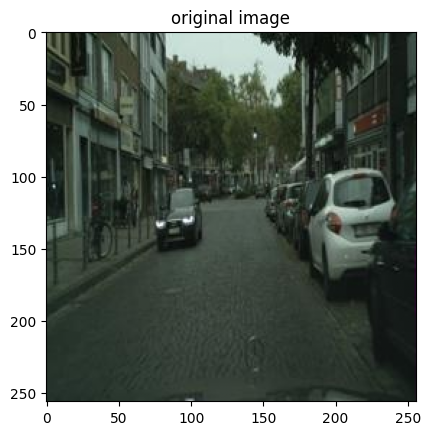

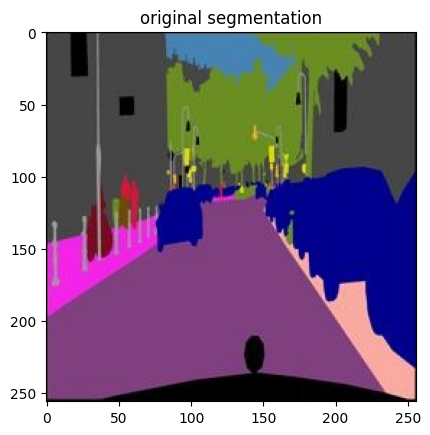

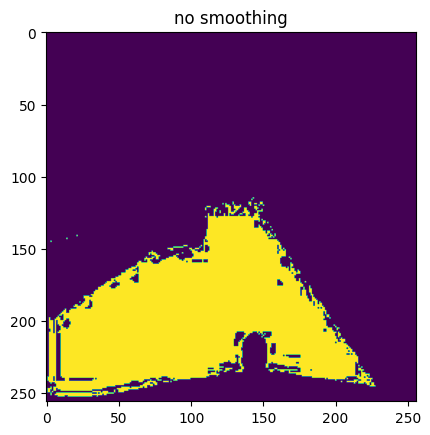

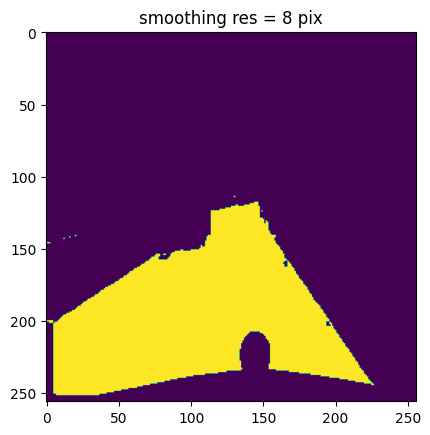

In [4]:
smooth_scale = 8
img1, img2, mask2, mask2_smoothed = preprocess(datapath+'train/100.jpg', smoothing_scale=smooth_scale)

plt.figure()
plt.imshow(img1)
plt.title('original image')
plt.figure()
plt.imshow(img2)
plt.title('original segmentation')


plt.figure()
plt.imshow(mask2)
plt.title('no smoothing')
plt.figure()
plt.title(f'smoothing res = {smooth_scale} pix')
plt.imshow(mask2_smoothed)




In [5]:
def prepare_tensor_dataset(train_path, val_path, smooth_scale = 8):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    for file in tqdm(os.listdir(train_path)):
        input, _, _, target = preprocess(f"{train_path}/{file}")
        X_train.append(input)
        Y_train.append(target)

    for file in tqdm(os.listdir(val_path)):
        input, _, _, target = preprocess(f"{val_path}/{file}")
        X_val.append(input)
        Y_val.append(target)

    return X_train, Y_train, X_val, Y_val

In [6]:
X_train, Y_train, X_valid, Y_valid = prepare_tensor_dataset(datapath+'train/',datapath+'val/')

100%|██████████| 500/500 [00:14<00:00, 34.55it/s]


In [7]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

# U-net Model

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def unet_2_downsamples(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)

    # Downsample path
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottom
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)

    # Upsample path
    up4 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv3)
    up4 = concatenate([up4, conv2], axis=3)
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(up4)
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(conv4)

    up5 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv1], axis=3)
    conv5 = Conv2D(32, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(32, 3, activation='relu', padding='same')(conv5)

    # Output layer
    output = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=output)
    return model

# Create the model
model = unet_2_downsamples()
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 256, 256, 32)         896       ['input_2[0][0]']             
                                                                                                  
 conv2d_12 (Conv2D)          (None, 256, 256, 32)         9248      ['conv2d_11[0][0]']           
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 128, 128, 32)         0         ['conv2d_12[0][0]']           
 g2D)                                                                                       

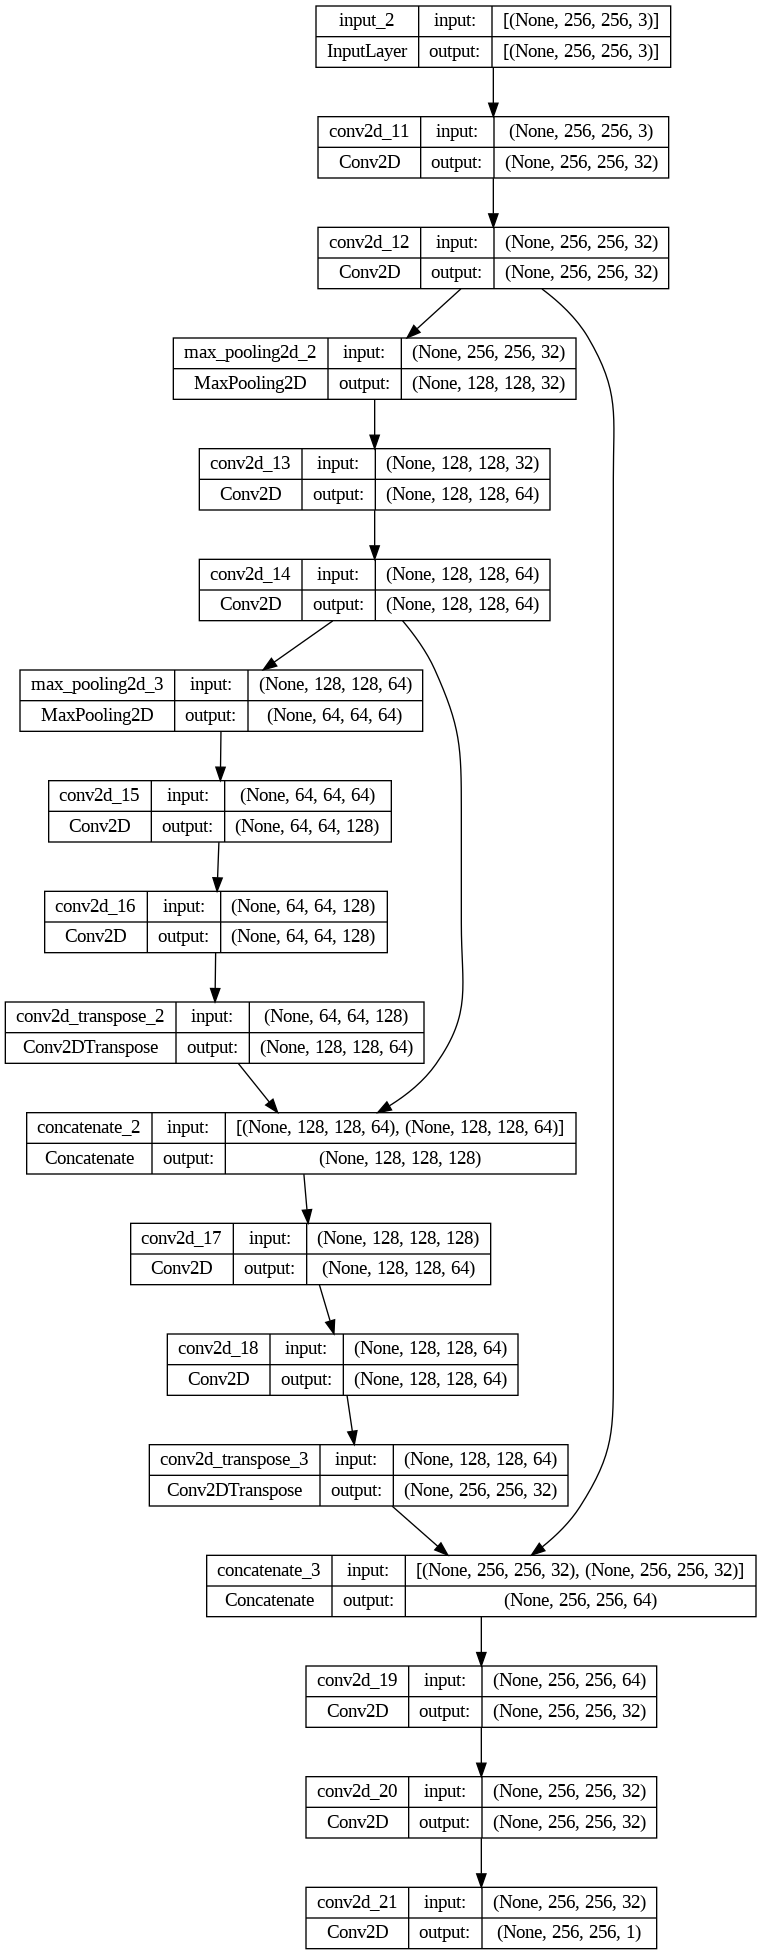

In [14]:
tf.keras.utils.plot_model(model, show_shapes = True)

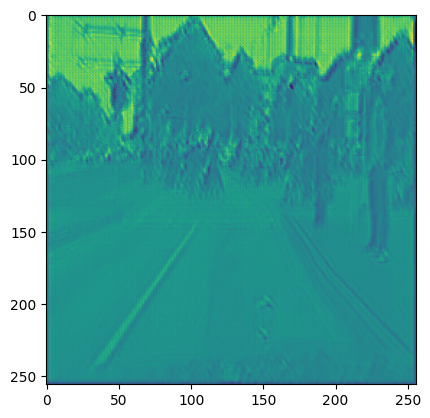

In [15]:
#process one image

pred = model(X_train[2:3])
plt.imshow(pred[0].numpy())

In [16]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

# Training

In [17]:
BATCH_SIZE = 32
history = model.fit(x=X_train, y=Y_train, epochs = 1, batch_size = BATCH_SIZE, validation_data = (X_valid, Y_valid))

42/42 [==============================] - 60s 1s/step - loss: -871.1595 - accuracy: 9.7953e-04 - val_loss: -1042.2699 - val_accuracy: 0.0000e+00


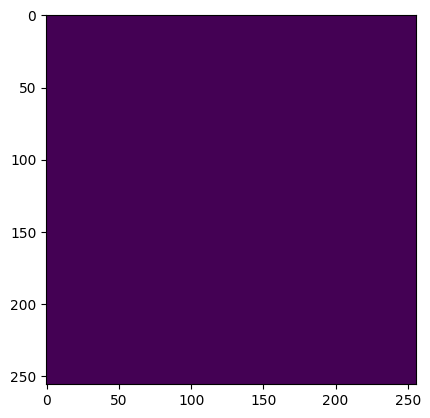

In [19]:
#process one image

pred = model(X_train[2:3])
plt.imshow(pred[0].numpy())